# Regression model to predict the salary of developers
Stack Overflow's Survey 2020

The goal of this project is to analyze the data from the 2020 Stack Overflow survey. More specifically, I am going to focus on  trying to predict the salary of developers using a linear regression.

## 1.- Gather

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from patsy import dmatrices
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('survey_results_public.csv')
schema = pd.read_csv('survey_results_schema.csv')
print(df.columns.tolist())

['Respondent', 'MainBranch', 'Hobbyist', 'Age', 'Age1stCode', 'CompFreq', 'CompTotal', 'ConvertedComp', 'Country', 'CurrencyDesc', 'CurrencySymbol', 'DatabaseDesireNextYear', 'DatabaseWorkedWith', 'DevType', 'EdLevel', 'Employment', 'Ethnicity', 'Gender', 'JobFactors', 'JobSat', 'JobSeek', 'LanguageDesireNextYear', 'LanguageWorkedWith', 'MiscTechDesireNextYear', 'MiscTechWorkedWith', 'NEWCollabToolsDesireNextYear', 'NEWCollabToolsWorkedWith', 'NEWDevOps', 'NEWDevOpsImpt', 'NEWEdImpt', 'NEWJobHunt', 'NEWJobHuntResearch', 'NEWLearn', 'NEWOffTopic', 'NEWOnboardGood', 'NEWOtherComms', 'NEWOvertime', 'NEWPurchaseResearch', 'NEWPurpleLink', 'NEWSOSites', 'NEWStuck', 'OpSys', 'OrgSize', 'PlatformDesireNextYear', 'PlatformWorkedWith', 'PurchaseWhat', 'Sexuality', 'SOAccount', 'SOComm', 'SOPartFreq', 'SOVisitFreq', 'SurveyEase', 'SurveyLength', 'Trans', 'UndergradMajor', 'WebframeDesireNextYear', 'WebframeWorkedWith', 'WelcomeChange', 'WorkWeekHrs', 'YearsCode', 'YearsCodePro']


## 2.- Assess

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Respondent                    64461 non-null  int64  
 1   MainBranch                    64162 non-null  object 
 2   Hobbyist                      64416 non-null  object 
 3   Age                           45446 non-null  float64
 4   Age1stCode                    57900 non-null  object 
 5   CompFreq                      40069 non-null  object 
 6   CompTotal                     34826 non-null  float64
 7   ConvertedComp                 34756 non-null  float64
 8   Country                       64072 non-null  object 
 9   CurrencyDesc                  45472 non-null  object 
 10  CurrencySymbol                45472 non-null  object 
 11  DatabaseDesireNextYear        44070 non-null  object 
 12  DatabaseWorkedWith            49537 non-null  object 
 13  D

In [4]:
df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [5]:
def get_description_and_unique (col_name, schema = schema):
    
    '''
    Gives the description of a column and its unique values
    '''

    description = list(schema[schema['Column'] == col_name]['QuestionText'])[0]
    unique_values = df[col_name].unique()
    return description, unique_values

In [6]:
get_description_and_unique('ConvertedComp')

('Salary converted to annual USD salaries using the exchange rate on 2020-02-19, assuming 12 working months and 50 working weeks.',
 array([    nan, 116000.,  32315., ...,    369.,    200.,  38759.]))

In [7]:
def miss_data(df):
    
    '''
    This function gives the amount of missing data, percentage and  absolute value, of a dataset by column.
    '''
    missing_data = pd.DataFrame(columns = ['column_name','missing_data', 'missing_in_percentage'])
    columns = df.columns
    for col in columns:
        missing_sum = df[col].isnull().sum()
        missing_percentage = (df[col].isnull().mean())*100     
        missing_data.loc[len(missing_data)] = [col, missing_sum, missing_percentage]
    print(missing_data) 

## 3.- Clean

In [8]:
#Convert JobSat and YearsCode to numeric
scale_mapper = {'Very dissatisfied':1, 'Slightly dissatisfied':2, 'Neither satisfied nor dissatisfied':3,
               'Slightly satisfied':4, 'Very satisfied':5}
df['JobSat'] = df['JobSat'].replace(scale_mapper)

df.loc[df.YearsCode == 'Less than 1 year', 'YearsCode'] = 0.5
df.loc[df.YearsCode == 'More than 50 years', 'YearsCode'] = 50.5
df['YearsCode'] = df['YearsCode'].astype(float)

In [9]:
#Chosen numeric variables
df_selection = df[['YearsCode', 'Age', 'ConvertedComp', 'JobSat', 'WorkWeekHrs' ]]

In [10]:
miss_data(df_selection)

     column_name missing_data  missing_in_percentage
0      YearsCode         6777              10.513334
1            Age        19015              29.498456
2  ConvertedComp        29705              46.082127
3         JobSat        19267              29.889390
4    WorkWeekHrs        23310              36.161400


### 3.1.- Work with Nan values

In [11]:
#As the variables in df_selection are all numeric and the linear regression function does not accept Nan values
#let's try to fill the missing values with the mean to have a a bigger dataset
fill_mean = lambda col: col.fillna(col.mean())

In [12]:
#Since I need to predict the salary I cannot fill the mean of the predictor as it would damage the efficiency of the model
#Therefore I am going to drop all rows with a Nan Salary
df_selection = df_selection.dropna(subset = ['ConvertedComp'], axis=0)

In [13]:
#Fill the Nan values with the mean of the column
num_vars = df_selection.select_dtypes(include=['float', 'int']).columns
for col in num_vars:
    df_selection[col] = df_selection[[col]].apply(fill_mean)

### 3.2.- Work with categorical variables

In [14]:
def dummy_array(df, col_list):
    '''
    The columns in col_list must have each observation as an array with the elements separated by ';' 
    It creates dummy columns for each variable in col_list and removes the original column.
    '''

    #Create a dummy variable for each language or devtype
    for item in col_list:
        split = df[item].str.strip('[]').str.split('\s*;')
        dummy = (split.explode().str.get_dummies().sum(level=0).add_prefix(item + '_'))
        df = df.drop([item], 1).join([dummy])
    
    return df

In [15]:
def create_dummy_df(df, cat_cols):
    '''
    This function receives a dataframe and a list of the categorical columns you want to dummy.
    It returns a dataframe without the original columns you wanted to dummy and creates dummy columns for each variable
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
        except:
            continue
    return df

In [16]:
def clean_data_regression(df, response_var, array_cat_list, sum_reduce):
    
    '''
    This function receives the dataframe you want to clean, the response variable that you want to predict,
    a list of categorical columns that are array-like and the factor in which you want to reduce the X matrix 
    for the regression.
    
    It returns the cleaned and reduced 'X' matrix and 'y' vector ready for the regression.
    
    
    '''
    
    #Drop the rows with missing values in the response_var column
    df = df.dropna(subset = [response_var], axis=0)
    y = df[response_var]
    
    #Drop the response_var column from the dataframe
    df = df.drop([response_var, 'CompTotal', 'Respondent'], axis = 1)
    
    #Fill numeric columns with mean and categorical columns with mode
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col] = df[[col]].apply(fill_mean)
    
    #Dummy array-variables
    df = dummy_array(df, array_cat_list)    
    
    #Categorical values list
    cat_vars = (df.select_dtypes(include=['object'])).columns

    #Dummy normal categorical values
    df = create_dummy_df(df, cat_vars) 
    
    #Remove columns with any Nan
    df = df.dropna(axis=1, how='any')
    
    X = df.iloc[:, np.where((df.sum() > sum_reduce) == True)[0]]
    
    return X, y

## 4.- Analyze

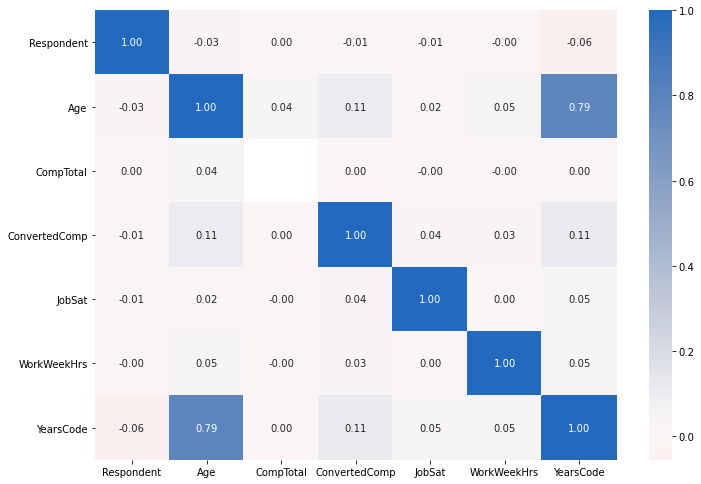

In [17]:
plt.figure(figsize = [11.69, 8.27])
sb.heatmap(df.corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0)
plt.show()

Most of the variables haven't a great correlation with the Salary ('ConvertedComp') but anyway I am going to continue with the regression and try to predict the best I can

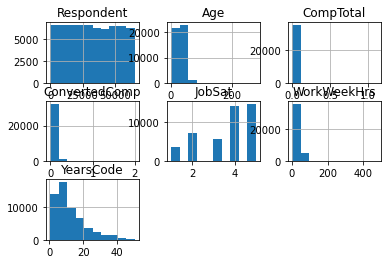

In [42]:
#Check distributions of the variables
df.hist();

## 5.- Model

### 5.1.- Regression 1

In [19]:
y = df_selection['ConvertedComp']
X = df_selection[['YearsCode', 'Age', 'JobSat', 'WorkWeekHrs' ]]

In [20]:
X.shape

(34756, 4)

In [21]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Instantiate
lm_model = LinearRegression(normalize=True);

#Fit
lm_model.fit(X_train, y_train)

#Predict
y_test_preds = lm_model.predict(X_test)

#Print R2 score and MSE
print(r2_score(y_test, y_test_preds))
print(mean_squared_error(y_test, y_test_preds))

0.014250298029528596
45316900198.21145


The prediction is very poor. I'm going to try to add the categorical values and dummy then.

### 5.2.- Regression 2

In [22]:
#Column list with categorical values with array structure
list_like_var = ['DevType', 'LanguageWorkedWith']

In [23]:
X2, y2 = clean_data_regression(df, 'ConvertedComp',list_like_var, 200)

In [24]:
X2.shape

(34756, 683)

In [25]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = .30, random_state=42)

#Instantiate
lm_model = LinearRegression(normalize=True);

#Fit
lm_model.fit(X_train, y_train)

#Predict
y_test_preds = lm_model.predict(X_test)

#Print R2 score and MSE of the test data
print(r2_score(y_test, y_test_preds))
print(mean_squared_error(y_test, y_test_preds))

0.24365424730646934
34770738374.70009


In [26]:
#Print R2 score and MSE of the train data
print(r2_score(y_train, lm_model.predict(X_train))) 
print(mean_squared_error(y_train, lm_model.predict(X_train)))

0.31895409457225654
36654497580.19782


In [27]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    This function is taken from the Udacity's Data Scientist Nanodegree
    
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

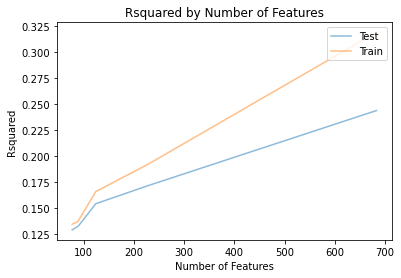

In [28]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X2, y2, cutoffs)

It seems that the predictions gets better with the number of features, let's try to increase them

### 5.3.- Regression 3

In [29]:
X3, y3 = clean_data_regression(df, 'ConvertedComp',list_like_var, 10)
X3.shape

(34756, 5083)

In [30]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size = .30, random_state=42)

#Instantiate
lm_model = LinearRegression(normalize=True);

#Fit
lm_model.fit(X_train, y_train)

#Predict
y_test_preds = lm_model.predict(X_test)

#Print R2 score and MSE of the test data
print(r2_score(y_test, y_test_preds))
print(mean_squared_error(y_test, y_test_preds))

0.05376273208616322
43500433982.5447


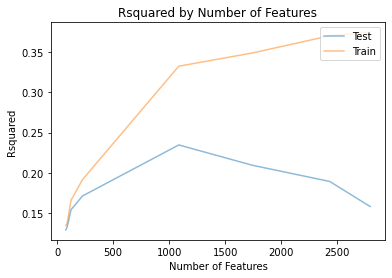

In [31]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X3, y3, cutoffs)

In [32]:
#Show coefficients for each variable

regressiong_coefficients = pd.DataFrame()
regressiong_coefficients['Variable'] = X_train.columns
regressiong_coefficients['Coefficient'] = lm_model.coef_
regressiong_coefficients['Absolute Coefficient'] = np.abs(lm_model.coef_)
regressiong_coefficients.sort_values('Coefficient', ascending=False).head(20)

,Variable,Coefficient,Absolute Coefficient
147,CurrencyDesc_Indonesian rupiah,1.030128e+19,1.030128e+19
169,CurrencySymbol_ARS,9.166949e+18,9.166949e+18
136,CurrencyDesc_Bangladeshi taka,6.308620e+18,6.308620e+18
188,CurrencySymbol_KRW,6.228299e+18,6.228299e+18
140,CurrencyDesc_Colombian peso,5.311375e+18,5.311375e+18
154,CurrencyDesc_Norwegian krone,4.830811e+18,4.830811e+18
167,CurrencyDesc_Ukrainian hryvnia,4.786747e+18,4.786747e+18
148,CurrencyDesc_Iranian rial,4.635893e+18,4.635893e+18
170,CurrencySymbol_AUD,4.353186e+18,4.353186e+18
142,CurrencyDesc_Czech koruna,4.005636e+18,4.005636e+18


The predictions are much worse, but it seems that for this model the best number of features is 1000, let's try again with this number of features approximately.

### 5.4.- Resgression 4

In [33]:
X4, y4 = clean_data_regression(df, 'ConvertedComp',list_like_var, 100)
X4.shape

(34756, 1086)

In [34]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X4, y4, test_size = .30, random_state=42)

#Instantiate
lm_model = LinearRegression(normalize=True);

#Fit
lm_model.fit(X_train, y_train)

#Predict
y_test_preds = lm_model.predict(X_test)

#Print R2 score and MSE of the test data
print(r2_score(y_test, y_test_preds))
print(mean_squared_error(y_test, y_test_preds))

0.23463227057188718
35185496825.50598


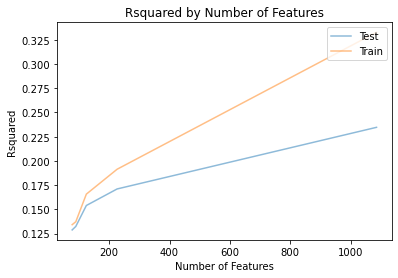

In [35]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X4, y4, cutoffs)

### 5.5.- Regression 5

It seems that the most important feature are the Currencies, which it does not makes sense for me. Let's check what happens is I remove these columns from the X matrix

In [36]:
df_remove = df.drop(columns = ['CurrencyDesc', 'CurrencySymbol'])


In [37]:
X5, y5 = clean_data_regression(df_remove, 'ConvertedComp',list_like_var, 100)
X5.shape

(34756, 1016)

In [38]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X5, y5, test_size = .30, random_state=42)

#Instantiate
lm_model = LinearRegression(normalize=True);

#Fit
lm_model.fit(X_train, y_train)

#Predict
y_test_preds = lm_model.predict(X_test)

#Print R2 score and MSE of the test data
print(r2_score(y_test, y_test_preds))
print(mean_squared_error(y_test, y_test_preds))

0.23554102105779373
35143719734.43248


It seems that I cannot improve my predictions, therefore the best model that I have created is the regression 2

### 5.6.- Best Regression Analysis

In [39]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = .30, random_state=42)

#Instantiate
lm_model = LinearRegression(normalize=True);

#Fit
lm_model.fit(X_train, y_train)

#Predict
y_test_preds = lm_model.predict(X_test)

## 6.- Visualize

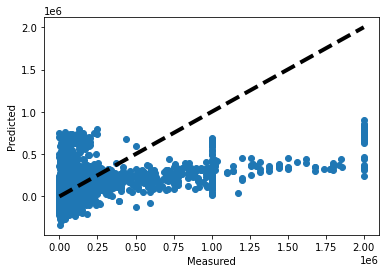

In [40]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_test_preds)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [41]:
#Show coefficients for each variable

regressiong_coefficients = pd.DataFrame()
regressiong_coefficients['Variable'] = X_train.columns
regressiong_coefficients['Coefficient'] = lm_model.coef_
regressiong_coefficients['Absolute Coefficient'] = np.abs(lm_model.coef_)
regressiong_coefficients.sort_values('Coefficient', ascending=False).head(20)

,Variable,Coefficient,Absolute Coefficient
141,CurrencySymbol_DKK,4.548210e+18,4.548210e+18
131,CurrencyDesc_Swiss franc,3.237905e+18,3.237905e+18
129,CurrencyDesc_South African rand,2.704086e+18,2.704086e+18
124,CurrencyDesc_Pakistani rupee,2.611641e+18,2.611641e+18
123,CurrencyDesc_Norwegian krone,2.555471e+18,2.555471e+18
125,CurrencyDesc_Polish zloty,2.430871e+18,2.430871e+18
118,CurrencyDesc_Hungarian forint,2.322595e+18,2.322595e+18
122,CurrencyDesc_Mexican peso,2.272394e+18,2.272394e+18
145,CurrencySymbol_ILS,2.212323e+18,2.212323e+18
152,CurrencySymbol_RON,1.392802e+18,1.392802e+18


I have only been able to create a model that explains 24% of the variability in wages, so it is not of much use.